In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math
import seaborn as sns


In [3]:
def basic_bispecific(t, z, Atot, r1tot, r2tot, k1, k2, koff, q1, q2, qoff):

    A00 = Atot - z[0] - z[1] - z[2]
    r1 = r1tot - z[0] - z[2]
    r2 = r2tot - z[1] - z[2]

    dA10 = k1*A00*r1 - koff*z[0] - q2*z[0]*r2 + qoff*z[2]
    dA01 = q1*A00*r2 - qoff*z[1] - k2*z[1]*r1 + koff*z[2]
    dA11 = q2*z[0]*r2 + k2*z[1]*r1 - (qoff + koff)*z[2]

    dz = [dA10, dA01, dA11]

    return dz

def dimensionless_bispecific(t, z, Atot, r1tot, r2tot, k1, k2, koff, q1, q2, qoff):

    A00 = Atot - z[0] - z[1] - z[2]
    r1 = r1tot - z[0] - z[2]
    r2 = r2tot - z[1] - z[2]

    dA10 = k1*A00*r1 - koff*z[0] - q2*z[0]*r2 + qoff*z[2]
    dA01 = q1*A00*r2 - qoff*z[1] - k2*z[1]*r1 + koff*z[2]
    dA11 = q2*z[0]*r2 + k2*z[1]*r1 - (qoff + koff)*z[2]

    dz = [dA10, dA01, dA11]

    return dz



In [4]:
def EC50_finder(array, A0s):
    half_max = 0.5*np.max(array) 
    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return A0s[indicies[0]]

In [5]:
Target_cell_number = 2e5
well_size = 125e-6
t_end = 60*60*100
t = np.geomspace(1e-5, t_end, 100)
t_span = [1e-10, t_end]
z0 = np.asarray([0, 0, 0])
tumour_cell_radius = 8e-6
sigma = well_size*N_A/Target_cell_number

r1tot = 1e3
r1tot = r1tot
r2tot = 1e5
r2tot = r2tot

kon = 10**(3.5)
k1 = kon/sigma
qon = 1e5
q1 = qon/sigma
koff = 10**(-3.5)
qoff = 1e-4

D1 = 1e-14
D2 = 1e-14
k2 = D1/(2*math.pi*(tumour_cell_radius**2))
q2 = D2/(2*math.pi*(tumour_cell_radius**2))

Ainit = 1e-11
Atot = Ainit*sigma

#solver = nbkode.BDF1(basic_bispecific, t0=0, y0=z0,  params=np.asarray([Atot, r1tot, r2tot, k1, k2, koff, q1, q2, qoff]))
z = solve_ivp(basic_bispecific, t_span, z0, method='Radau', t_eval=t, args= (Atot, r1tot, r2tot, k1, k2, koff, q1, q2, qoff))



In [6]:
A0s = np.geomspace(1e-13, 5e-5, 100)

def solve_bispecific(bound_ab, ro, Atot, r1tot, r2tot, k1, k2, koff, q1, q2, qoff):

    for j, Ainit in enumerate(A0s):
            # simulate binding
            Atot = Ainit*sigma
            z = solve_ivp(basic_bispecific, t_span, z0, method='Radau', t_eval=t, args= ((Atot, r1tot, r2tot, k1, k2, koff, q1, q2, qoff)))

            Ab = z.y[0] + z.y[1] + z.y[2]
            recep_oc = z.y[0] + z.y[2]
            bound_ab[j] = Ab[-1]
            ro[j] = recep_oc[-1]
    
    return [bound_ab, ro]

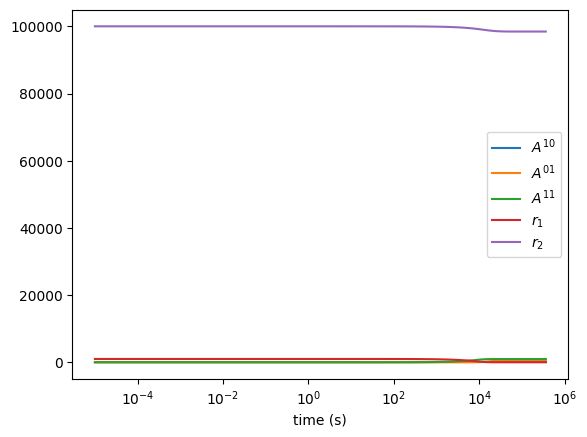

In [7]:
A10 = z.y[0]
A01 = z.y[1]
A11 = z.y[2]
r1 = (r1tot - z.y[0] - z.y[2])
r2 = (r2tot - z.y[1] - z.y[2])

plt.plot(t, A10, label=r'$A^{10}$')
plt.plot(t, A01, label=r'$A^{01}$')
plt.plot(t, A11, label=r'$A^{11}$')
plt.plot(t, r1, label=r'$r_1$')
plt.plot(t, r2, label=r'$r_2$')
plt.xscale('log')
plt.xlabel('time (s)')
plt.legend(loc='best')
plt.show()

In [8]:
A0s = np.geomspace(1e-13, 5e-5, 75)

qon_powers = np.linspace(5, 3, 250)
qoff_powers = np.linspace(-5, -3, 250)
rtot2s = np.linspace(3, 6, 250)
qons = np.flip(10**qon_powers)
qoffs = np.flip(10**qoff_powers)
rtot2s = 10**rtot2s
bound_ab_Ec50s = np.zeros_like(qon_powers)
ro_Ec50s = np.zeros_like(qon_powers)
Y = np.zeros((len(rtot2s), len(rtot2s)))
Y1 = np.zeros((len(rtot2s), len(rtot2s)))
r1tot = 1e5
for k, r2tot in enumerate(rtot2s):
    print(k)
    for i, qon in enumerate(qons):
        q1 = qon/sigma
        bound_ab = np.zeros_like(A0s)
        ro = np.zeros_like(A0s)
        qoff = qoffs[i]

        for j, Ainit in enumerate(A0s):
            # simulate binding
            Atot = Ainit*sigma
            z = solve_ivp(basic_bispecific, t_span, z0, method='Radau', t_eval=t, args= ((Atot, r1tot, r2tot, k1, k2, koff, q1, q2, qoff)))

            Ab = z.y[0] + z.y[1] + z.y[2]
            recep_oc = z.y[0] + z.y[2]
            bound_ab[j] = Ab[-1]
            ro[j] = recep_oc[-1]
       
        
        bound_ab_ec50 = EC50_finder(bound_ab, A0s)
        ro_ec50 = EC50_finder(ro, A0s)
        Y[i, k] = bound_ab_ec50
        Y1[i, k] = ro_ec50



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


<Axes: >

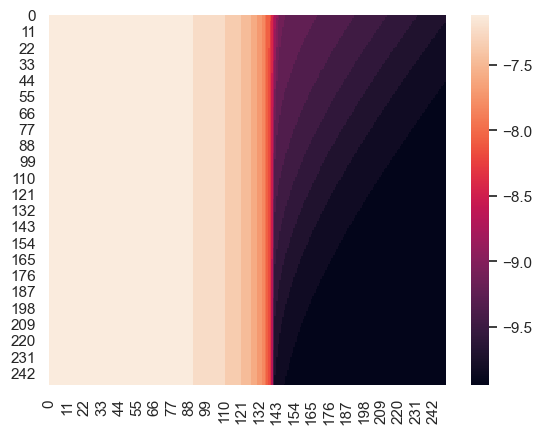

In [16]:
sns.heatmap(np.log10(Y1))

In [10]:
KD = 10**(-3.5)/10**3.5
KD

1e-07

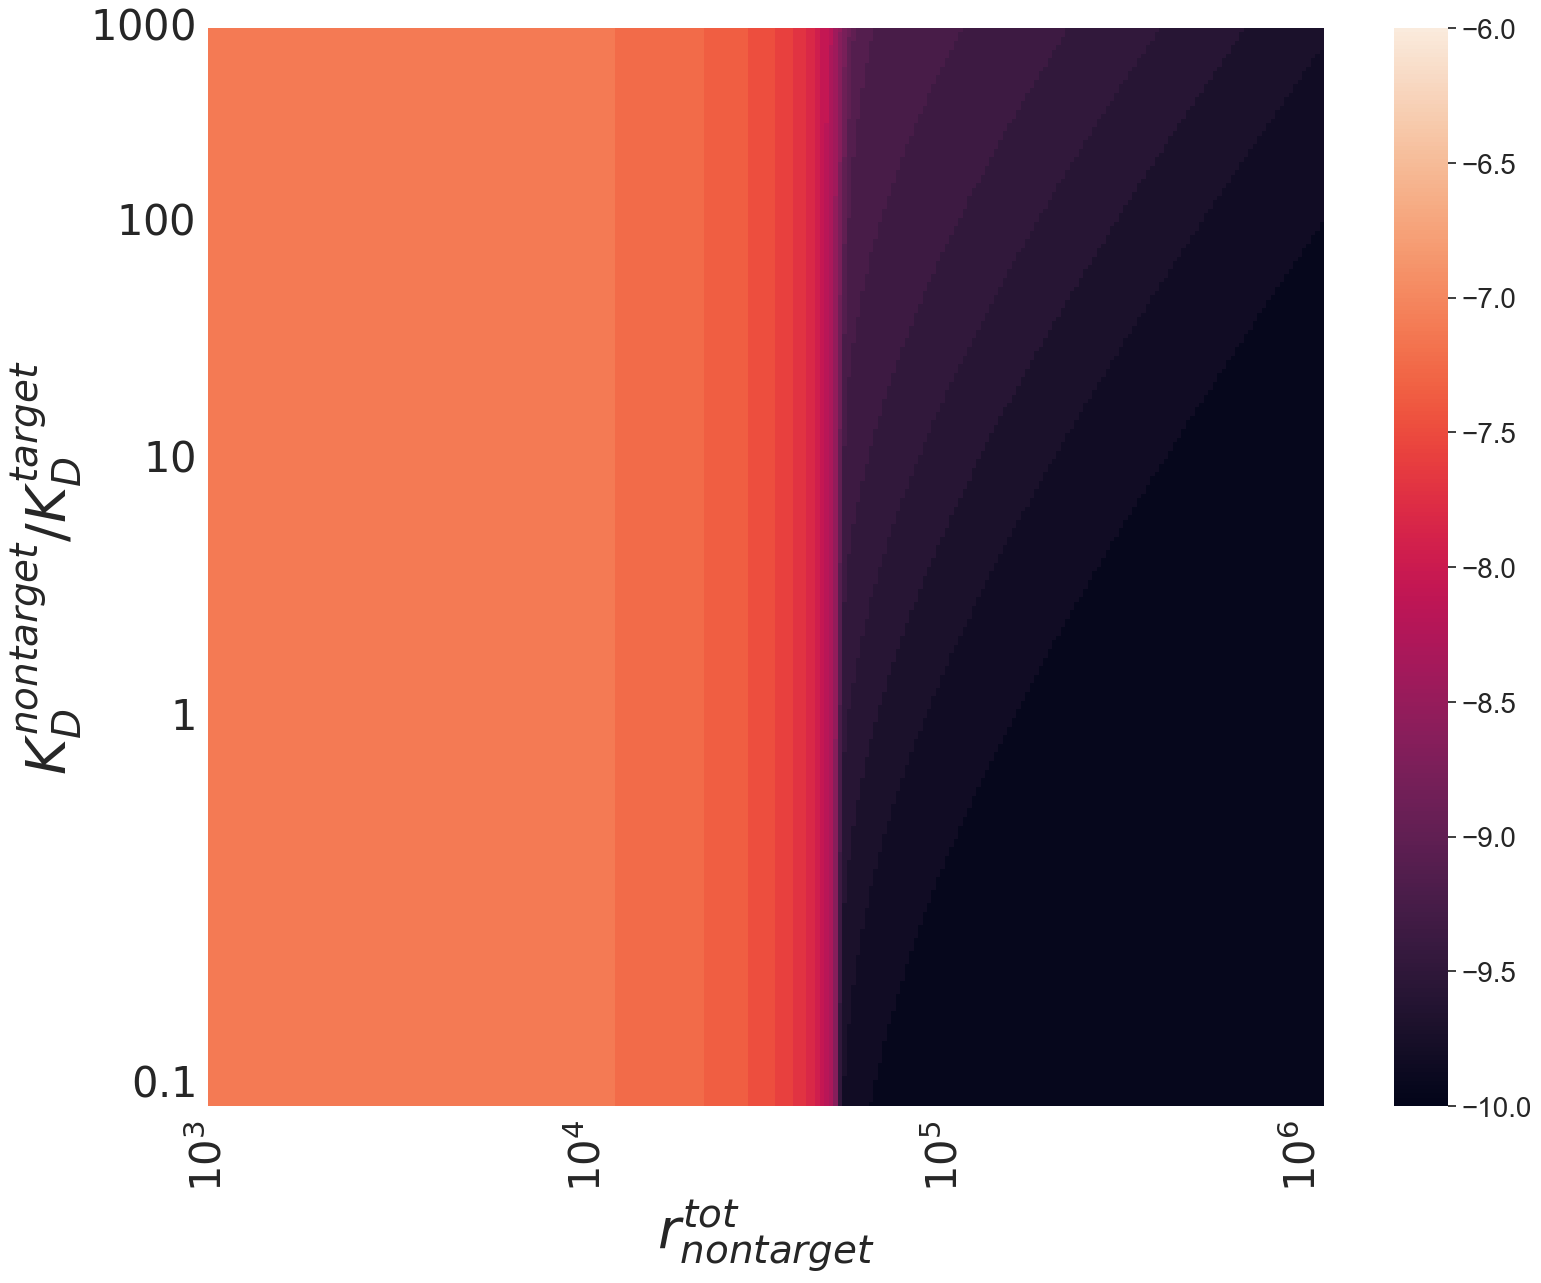

In [17]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(18, 14))
line = sns.heatmap(np.log10(Y1), xticklabels=True, yticklabels=True, ax=ax, vmin=-10, vmax = -6) 
ax.set_yticks([0, 9*5, 20*5, 32*5, 49*5])
ax.set_xticks([0, 17*5, 33*5, 49*5])
ax.set_yticklabels(np.flip([r'$0.1$', r'$1$',r'$10$', r'$100$', r'$1000$']), fontsize=30)
ax.set_xticklabels([r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$'], fontsize=30)
ax.set_xlabel(r'$r^{tot}_{nontarget}$', fontsize=40)
ax.set_ylabel(r'$K_D^{nontarget}/K_D^{target}$', fontsize=40)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/Selectivity_figures/bound_antibody_bispecific_target_ec50_heatmap_target_KD_100nm_rtot_targ_1e5_D_1e-14.png')